<a href="https://colab.research.google.com/github/harshnilve28/ML-Renewable-Energy-Forecasting/blob/main/ds_proj_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
class SimpleRenewableForecaster:
    """
    Simplified renewable energy forecasting pipeline
    Focus on speed and interpretability over complex deep learning
    """
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_importance = {}
        self.results = {}
        print("✅ SimpleRenewableForecaster initialized!")

    def load_data(self, file_path):
        """Load and basic preprocessing of renewable energy data"""
        print("📊 Loading renewable energy dataset...")
        # Load data
        self.df = pd.read_csv('/content/Renewable_energy_dataset.csv')
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df = self.df.set_index('timestamp').sort_index()

        print(f"✅ Dataset loaded: {self.df.shape[0]} records from {self.df.index[0]} to {self.df.index[-1]}")
        print(f"Features: {list(self.df.columns)}")
        return self.df


In [ ]:
def create_simple_features(self):
    """Create essential time-based and weather features"""
    print("Creating simple features...")

    # Time-based features
    self.df['hour'] = self.df.index.hour
    self.df['day_of_week'] = self.df.index.dayofweek
    self.df['month'] = self.df.index.month
    self.df['is_weekend'] = (self.df.index.dayofweek >= 5).astype(int)

    # Simple cyclical features
    self.df['hour_sin'] = np.sin(2 * np.pi * self.df['hour'] / 24)
    self.df['hour_cos'] = np.cos(2 * np.pi * self.df['hour'] / 24)

    # Simple lag features (just 1 and 24 hours)
    self.df['solar_lag_1h'] = self.df['solar_pv_output'].shift(1)
    self.df['solar_lag_24h'] = self.df['solar_pv_output'].shift(24)
    self.df['wind_lag_1h'] = self.df['wind_power_output'].shift(1)
    self.df['wind_lag_24h'] = self.df['wind_power_output'].shift(24)

    # Simple rolling averages
    self.df['solar_avg_6h'] = self.df['solar_pv_output'].rolling(6).mean()
    self.df['wind_avg_6h'] = self.df['wind_power_output'].rolling(6).mean()

    # Remove rows with NaN values
    self.df = self.df.dropna()
    print(f"✅ Features created. Clean dataset: {len(self.df)} records")

def get_features_for_target(self, target):
    """Get relevant features for each target variable"""
    base_features = ['hour', 'day_of_week', 'month', 'is_weekend',
                    'hour_sin', 'hour_cos', 'temperature', 'humidity']

    if target == 'solar_pv_output':
        specific_features = ['solar_irradiance', 'solar_lag_1h', 'solar_lag_24h', 'solar_avg_6h']
    elif target == 'wind_power_output':
        specific_features = ['wind_speed', 'atmospheric_pressure', 'wind_lag_1h', 'wind_lag_24h', 'wind_avg_6h']
    else:  # total_renewable_energy
        specific_features = ['solar_irradiance', 'wind_speed', 'grid_load_demand']

    all_features = base_features + specific_features
    # Only keep features that exist in the dataset
    return [f for f in all_features if f in self.df.columns]

# Add methods to the class
SimpleRenewableForecaster.create_simple_features = create_simple_features
SimpleRenewableForecaster.get_features_for_target = get_features_for_target

In [ ]:
#Model Training Methods
def train_simple_models(self, target, test_size=0.2):
    """Train simple but effective models"""
    print(f"Training models for {target}...")
    features = self.get_features_for_target(target)
    X = self.df[features]
    y = self.df[target]
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[name] = {
            'model': model,
            'mae': mae,
            'rmse': rmse,
            'y_test': y_test,
            'y_pred': y_pred,
            'correlation': np.corrcoef(y_test, y_pred)[0, 1]
        }

        print(f"  📈 {name}: MAE={mae:.2f}, RMSE={rmse:.2f}, Correlation={results[name]['correlation']:.3f}")

    # Store best model and scaler
    best_model_name = min(results.keys(), key=lambda k: results[k]['mae'])
    self.models[target] = results[best_model_name]['model']
    self.scalers[target] = scaler
    self.results[target] = results

    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        importance = pd.DataFrame({
            'feature': features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        self.feature_importance[target] = importance

    print(f"✅ Best model for {target}: {best_model_name}")
    return results

# Add method to the class
SimpleRenewableForecaster.train_simple_models = train_simple_models


In [ ]:
#Prediction and Metrics Methods
def predict_next_hours(self, target, hours_ahead=24):
    """Simple multi-step ahead forecasting"""
    print(f"Predicting {target} for next {hours_ahead} hours...")

    model = self.models[target]
    scaler = self.scalers[target]
    features = self.get_features_for_target(target)

    # Use last available data point as starting point
    last_data = self.df[features].iloc[-1:].copy()
    predictions = []
    current_time = self.df.index[-1]

    for h in range(1, hours_ahead + 1):
        # Update time features for next hour
        next_time = current_time + pd.Timedelta(hours=h)
        last_data.loc[last_data.index[0], 'hour'] = next_time.hour
        last_data.loc[last_data.index[0], 'day_of_week'] = next_time.dayofweek
        last_data.loc[last_data.index[0], 'month'] = next_time.month
        last_data.loc[last_data.index[0], 'is_weekend'] = int(next_time.dayofweek >= 5)
        last_data.loc[last_data.index[0], 'hour_sin'] = np.sin(2 * np.pi * next_time.hour / 24)
        last_data.loc[last_data.index[0], 'hour_cos'] = np.cos(2 * np.pi * next_time.hour / 24)

        # Make prediction
        X_scaled = scaler.transform(last_data)
        pred = model.predict(X_scaled)[0]
        predictions.append(max(0, pred))  #non-negative

    return np.array(predictions)

def calculate_simple_metrics(self, target):
    """Calculate energy-specific metrics"""
    if target not in self.results:
        return None

    # Get best model results
    best_result = min(self.results[target].values(), key=lambda x: x['mae'])
    y_true = best_result['y_test']
    y_pred = best_result['y_pred']

    # Capacity estimates from data
    capacity = self.df[target].max()

    metrics = {
        'MAE': best_result['mae'],
        'RMSE': best_result['rmse'],
        'nMAE (%)': (best_result['mae'] / capacity) * 100,
        'nRMSE (%)': (best_result['rmse'] / capacity) * 100,
        'Correlation': best_result['correlation'],
        'Max Error': np.max(np.abs(y_true - y_pred)),
        'Mean Absolute % Error': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

    return metrics

# Add methods to the class
SimpleRenewableForecaster.predict_next_hours = predict_next_hours
SimpleRenewableForecaster.calculate_simple_metrics = calculate_simple_metrics


In [ ]:
#Visualization Methods
def plot_results(self, target):
    """Create comprehensive plots for results"""
    if target not in self.results:
        print(f"No results available for {target}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Forecasting Results: {target.replace("_", " ").title()}', fontsize=16)

    # Get best model results
    best_result = min(self.results[target].values(), key=lambda x: x['mae'])
    y_true = best_result['y_test']
    y_pred = best_result['y_pred']

    # 1. Time series comparison (last 168 hours = 1 week)
    axes[0,0].plot(y_true.index[-168:], y_true.iloc[-168:], 'b-', label='Actual', linewidth=2)
    axes[0,0].plot(y_true.index[-168:], y_pred[-168:], 'r--', label='Predicted', linewidth=2)
    axes[0,0].set_title('Last Week: Actual vs Predicted')
    axes[0,0].set_ylabel('Power (MW)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Scatter plot
    axes[0,1].scatter(y_true, y_pred, alpha=0.5)
    axes[0,1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual (MW)')
    axes[0,1].set_ylabel('Predicted (MW)')
    axes[0,1].set_title(f'Correlation: {best_result["correlation"]:.3f}')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Error distribution
    errors = y_true - y_pred
    axes[1,0].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Prediction Error (MW)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title(f'Error Distribution (MAE: {best_result["mae"]:.2f})')
    axes[1,0].grid(True, alpha=0.3)

    # 4. Feature importance
    if target in self.feature_importance:
        importance = self.feature_importance[target].head(10)
        axes[1,1].barh(range(len(importance)), importance['importance'])
        axes[1,1].set_yticks(range(len(importance)))
        axes[1,1].set_yticklabels(importance['feature'])
        axes[1,1].set_xlabel('Feature Importance')
        axes[1,1].set_title('Top 10 Important Features')
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Add method to the class
SimpleRenewableForecaster.plot_results = plot_results


In [ ]:
#Report Generation
def generate_forecast_report(self):
    """Generate a comprehensive forecast report with hour-by-hour predictions"""
    print("\n" + "="*80)
    print("RENEWABLE ENERGY FORECASTING REPORT")
    print("="*80)

    targets = ['solar_pv_output', 'wind_power_output', 'total_renewable_energy']

    for target in targets:
        if target in self.df.columns and target in self.results:
            print(f"\n📊 {target.replace('_', ' ').upper()}")
            print("-" * 50)

            # Model performance metrics
            metrics = self.calculate_simple_metrics(target)
            if metrics:
                for metric, value in metrics.items():
                    if 'Correlation' in metric:
                        print(f"{metric:<25}: {value:.3f}")
                    elif '%' in metric:
                        print(f"{metric:<25}: {value:.2f}%")
                    else:
                        print(f"{metric:<25}: {value:.2f} MW")

            # Feature importance
            if target in self.feature_importance:
                print(f"\nTop 5 Important Features:")
                top_features = self.feature_importance[target].head(5)
                for _, row in top_features.iterrows():
                    print(f"  • {row['feature']:<20}: {row['importance']:.3f}")

            # DETAILED HOUR-BY-HOUR FORECAST
            forecast_24h = self.predict_next_hours(target, 24)
            current_time = self.df.index[-1]

            print(f"\n DETAILED NEXT 24H FORECAST:")
            print(f"Starting from: {current_time}")
            print("-" * 60)
            print(f"{'Hour':<8} {'Time':<8} {'Predicted MW':<15} {'Cumulative MWh':<15}")
            print("-" * 60)

            cumulative_energy = 0
            for hour in range(24):
                future_time = current_time + pd.Timedelta(hours=hour+1)
                hour_str = f"+{hour+1}h"
                time_str = f"{future_time.hour:02d}:00"
                power_mw = forecast_24h[hour]
                cumulative_energy += power_mw

                print(f"{hour_str:<8} {time_str:<8} {power_mw:<15.2f} {cumulative_energy:<15.2f}")

            # Summary statistics
            print(f"\n📈 24-HOUR SUMMARY:")
            print(f"  • Average: {forecast_24h.mean():.2f} MW")
            print(f"  • Range: {forecast_24h.min():.2f} - {forecast_24h.max():.2f} MW")
            print(f"  • Peak hour: +{forecast_24h.argmax()+1}h ahead ({forecast_24h.max():.2f} MW)")
            print(f"  • Minimum hour: +{forecast_24h.argmin()+1}h ahead ({forecast_24h.min():.2f} MW)")
            print(f"  • Total Energy: {forecast_24h.sum():.2f} MWh")
            print(f"  • Standard Deviation: {forecast_24h.std():.2f} MW")

            # Best consecutive 6-hour periods
            best_6h_start = 0
            best_6h_avg = 0
            worst_6h_start = 0
            worst_6h_avg = float('inf')

            for i in range(19):  # 24-6+1
                period_avg = forecast_24h[i:i+6].mean()
                if period_avg > best_6h_avg:
                    best_6h_avg = period_avg
                    best_6h_start = i
                if period_avg < worst_6h_avg:
                    worst_6h_avg = period_avg
                    worst_6h_start = i

            print(f"\n⭐ OPTIMAL PERIODS:")
            print(f"  • Best 6h: Hours +{best_6h_start+1} to +{best_6h_start+6} (Avg: {best_6h_avg:.2f} MW)")
            print(f"  • Lowest 6h: Hours +{worst_6h_start+1} to +{worst_6h_start+6} (Avg: {worst_6h_avg:.2f} MW)")

# Update the class method
SimpleRenewableForecaster.generate_forecast_report = generate_forecast_report

print("✅ Enhanced hourly prediction report updated!")


✅ Enhanced hourly prediction report updated!


In [ ]:
#Demo Function
def run_simple_forecasting_demo():
    """Complete demo of the simplified forecasting pipeline"""
    print("Starting Simplified Renewable Energy Forecasting Pipeline")
    print("="*70)

    forecaster = SimpleRenewableForecaster()
    df = forecaster.load_data('Renewable_energy_dataset.csv')
    forecaster.create_simple_features()

    # Show basic data info
    print("\n📈 Dataset Overview:")
    print(f"Solar PV: {df['solar_pv_output'].min():.1f} - {df['solar_pv_output'].max():.1f} MW")
    print(f"Wind Power: {df['wind_power_output'].min():.1f} - {df['wind_power_output'].max():.1f} MW")
    print(f"Total Renewable: {df['total_renewable_energy'].min():.1f} - {df['total_renewable_energy'].max():.1f} MW")

    return forecaster

print("✅ Demo function ready!")


✅ Demo function ready!


In [ ]:
forecaster = run_simple_forecasting_demo()

Starting Simplified Renewable Energy Forecasting Pipeline
✅ SimpleRenewableForecaster initialized!
📊 Loading renewable energy dataset...
✅ Dataset loaded: 3546 records from 2023-01-01 00:00:00 to 2023-05-28 17:00:00
Features: ['solar_pv_output', 'wind_power_output', 'total_renewable_energy', 'solar_irradiance', 'wind_speed', 'temperature', 'humidity', 'atmospheric_pressure', 'grid_load_demand', 'frequency', 'voltage', 'power_exchange', 'battery_state_of_charge', 'battery_charging_rate', 'battery_discharging_rate', 'hour_of_day', 'day_of_week', 'predicted_solar_pv_output', 'predicted_wind_power_output', 'total_predicted_energy']
Creating simple features...
✅ Features created. Clean dataset: 3522 records

📈 Dataset Overview:
Solar PV: 0.0 - 100.0 MW
Wind Power: 0.0 - 100.0 MW
Total Renewable: 2.1 - 197.7 MW


In [ ]:
#rain Solar PV Models
print("="*50)
print("🌞 SOLAR PV FORECASTING")
print("="*50)
solar_results = forecaster.train_simple_models('solar_pv_output')

🌞 SOLAR PV FORECASTING
Training models for solar_pv_output...
  📈 Linear Regression: MAE=21.93, RMSE=25.82, Correlation=0.440
  📈 Random Forest: MAE=22.52, RMSE=26.66, Correlation=0.383
✅ Best model for solar_pv_output: Linear Regression


In [ ]:
#Train Wind Power Models
print("="*50)
print("💨 WIND POWER FORECASTING")
print("="*50)
wind_results = forecaster.train_simple_models('wind_power_output')

💨 WIND POWER FORECASTING
Training models for wind_power_output...
  📈 Linear Regression: MAE=22.22, RMSE=26.43, Correlation=0.412
  📈 Random Forest: MAE=22.91, RMSE=27.44, Correlation=0.341
✅ Best model for wind_power_output: Linear Regression


In [ ]:
#Train Total Renewable Energy Models
print("="*50)
print("⚡ TOTAL RENEWABLE ENERGY FORECASTING")
print("="*50)
total_results = forecaster.train_simple_models('total_renewable_energy')

⚡ TOTAL RENEWABLE ENERGY FORECASTING
Training models for total_renewable_energy...
  📈 Linear Regression: MAE=34.29, RMSE=41.90, Correlation=0.072
  📈 Random Forest: MAE=35.13, RMSE=42.92, Correlation=0.012
✅ Best model for total_renewable_energy: Linear Regression


In [ ]:
#Summary
def show_quick_hourly_predictions(target='solar_pv_output', hours=12):
    """Show a quick hourly prediction summary"""
    if target not in forecaster.models:
        print(f"No trained model found for {target}")
        return

    print(f"\n⚡ QUICK {hours}H PREDICTION: {target.replace('_', ' ').upper()}")
    print("="*50)

    forecast = forecaster.predict_next_hours(target, hours)
    current_time = forecaster.df.index[-1]

    for hour in range(hours):
        future_time = current_time + pd.Timedelta(hours=hour+1)
        time_str = future_time.strftime('%H:%M')
        power = forecast[hour]
        print(f"  +{hour+1:2d}h ({time_str}): {power:6.2f} MW")

    print(f"\n📊 Summary:")
    print(f"  Average: {forecast.mean():.2f} MW")
    print(f"  Peak: {forecast.max():.2f} MW at +{forecast.argmax()+1}h")
    print(f"  Minimum: {forecast.min():.2f} MW at +{forecast.argmin()+1}h")

# Quick examples - run any of these:
show_quick_hourly_predictions('solar_pv_output', 12)
show_quick_hourly_predictions('wind_power_output', 24)
show_quick_hourly_predictions('total_renewable_energy', 6)



⚡ QUICK 12H PREDICTION: SOLAR PV OUTPUT
Predicting solar_pv_output for next 12 hours...
  + 1h (18:00):  32.44 MW
  + 2h (19:00):  32.96 MW
  + 3h (20:00):  33.56 MW
  + 4h (21:00):  34.20 MW
  + 5h (22:00):  34.86 MW
  + 6h (23:00):  35.48 MW
  + 7h (00:00):  33.08 MW
  + 8h (01:00):  33.56 MW
  + 9h (02:00):  33.92 MW
  +10h (03:00):  34.15 MW
  +11h (04:00):  34.24 MW
  +12h (05:00):  34.20 MW

📊 Summary:
  Average: 33.89 MW
  Peak: 35.48 MW at +6h
  Minimum: 32.44 MW at +1h

⚡ QUICK 24H PREDICTION: WIND POWER OUTPUT
Predicting wind_power_output for next 24 hours...
  + 1h (18:00):  52.32 MW
  + 2h (19:00):  52.17 MW
  + 3h (20:00):  51.97 MW
  + 4h (21:00):  51.73 MW
  + 5h (22:00):  51.46 MW
  + 6h (23:00):  51.17 MW
  + 7h (00:00):  53.60 MW
  + 8h (01:00):  53.31 MW
  + 9h (02:00):  53.04 MW
  +10h (03:00):  52.80 MW
  +11h (04:00):  52.60 MW
  +12h (05:00):  52.44 MW
  +13h (06:00):  52.33 MW
  +14h (07:00):  52.27 MW
  +15h (08:00):  52.26 MW
  +16h (09:00):  52.29 MW
  +17h 

In [ ]:
forecaster.generate_forecast_report()


RENEWABLE ENERGY FORECASTING REPORT

📊 SOLAR PV OUTPUT
--------------------------------------------------
MAE                      : 21.93 MW
RMSE                     : 25.82 MW
nMAE (%)                 : 21.94%
nRMSE (%)                : 25.83%
Correlation              : 0.440
Max Error                : 64.16 MW
Mean Absolute % Error    : 2799.62%

Top 5 Important Features:
  • solar_avg_6h        : 0.280
  • solar_lag_1h        : 0.127
  • temperature         : 0.100
  • humidity            : 0.099
  • solar_irradiance    : 0.099
Predicting solar_pv_output for next 24 hours...

 DETAILED NEXT 24H FORECAST:
Starting from: 2023-05-28 17:00:00
------------------------------------------------------------
Hour     Time     Predicted MW    Cumulative MWh 
------------------------------------------------------------
+1h      18:00    32.44           32.44          
+2h      19:00    32.96           65.41          
+3h      20:00    33.56           98.97          
+4h      21:00    34.20   

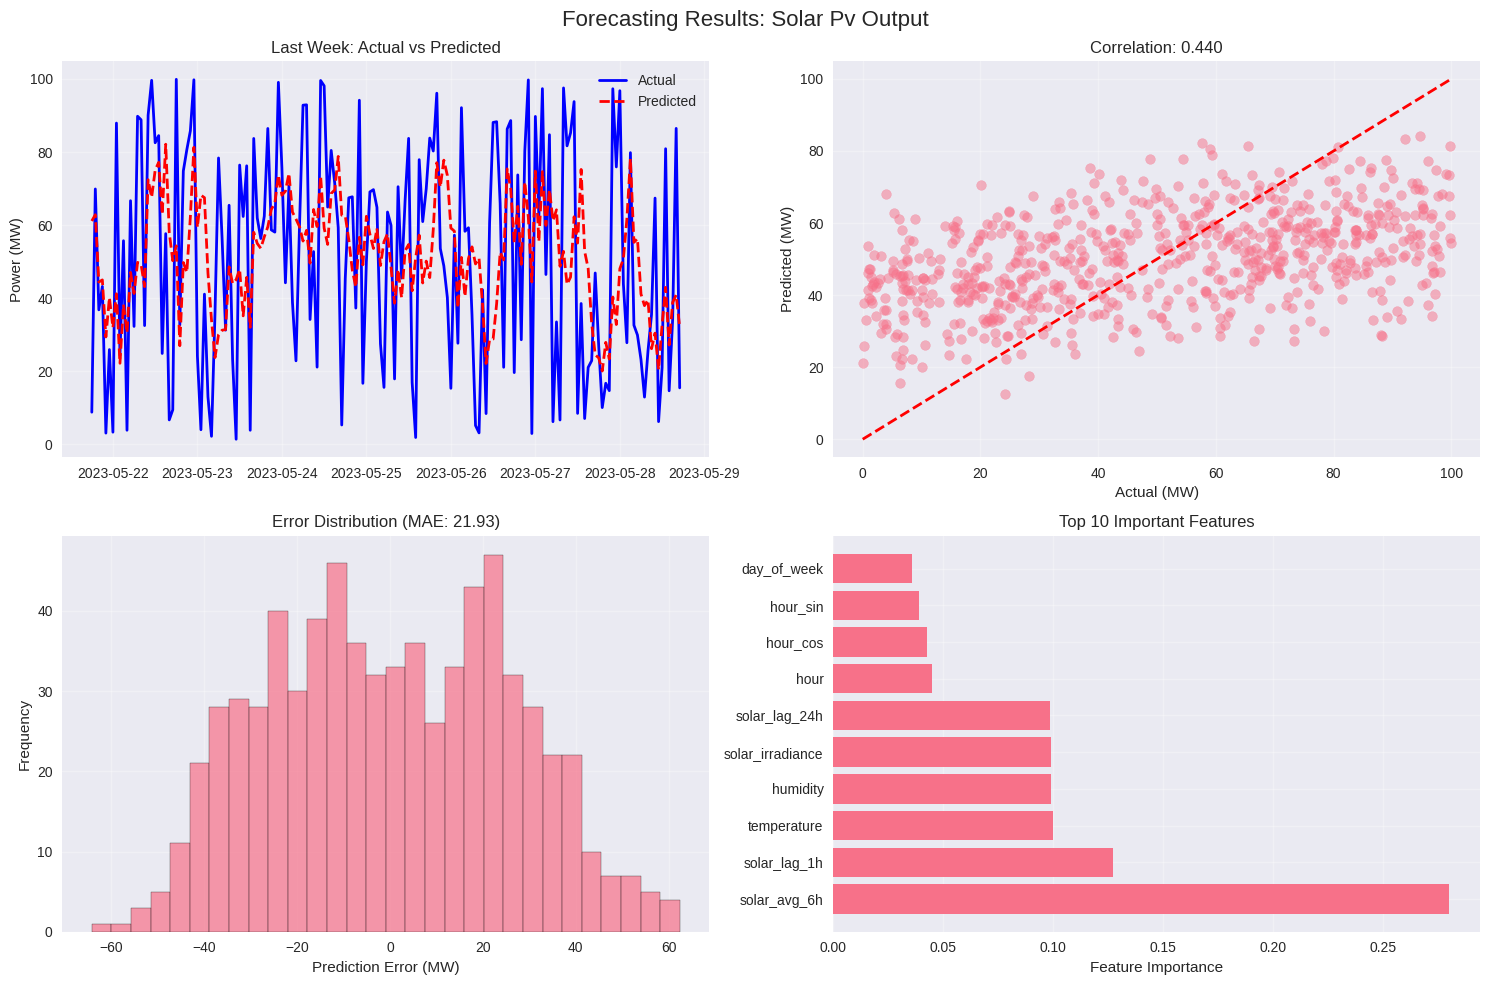

In [ ]:
#Solar PV Visualization
forecaster.plot_results('solar_pv_output')

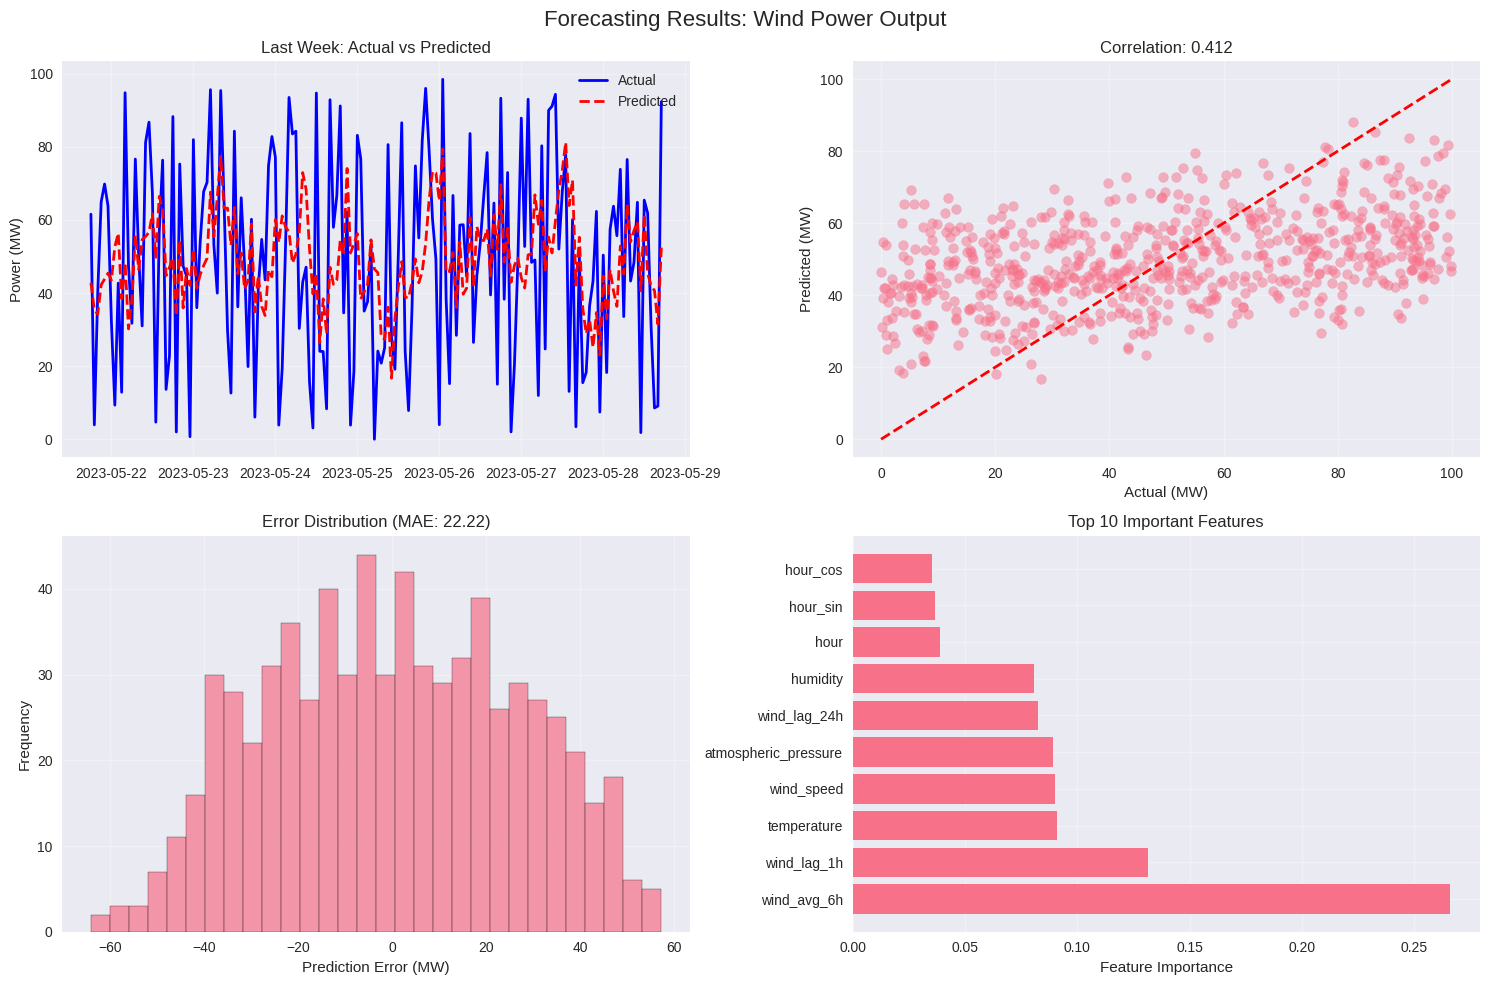

In [ ]:
#Wind Power Visualization
forecaster.plot_results('wind_power_output')

Predicting solar_pv_output for next 6 hours...
Predicting solar_pv_output for next 12 hours...
Predicting solar_pv_output for next 24 hours...
Predicting solar_pv_output for next 48 hours...
Predicting wind_power_output for next 6 hours...
Predicting wind_power_output for next 12 hours...
Predicting wind_power_output for next 24 hours...
Predicting wind_power_output for next 48 hours...
Predicting total_renewable_energy for next 6 hours...
Predicting total_renewable_energy for next 12 hours...
Predicting total_renewable_energy for next 24 hours...
Predicting total_renewable_energy for next 48 hours...


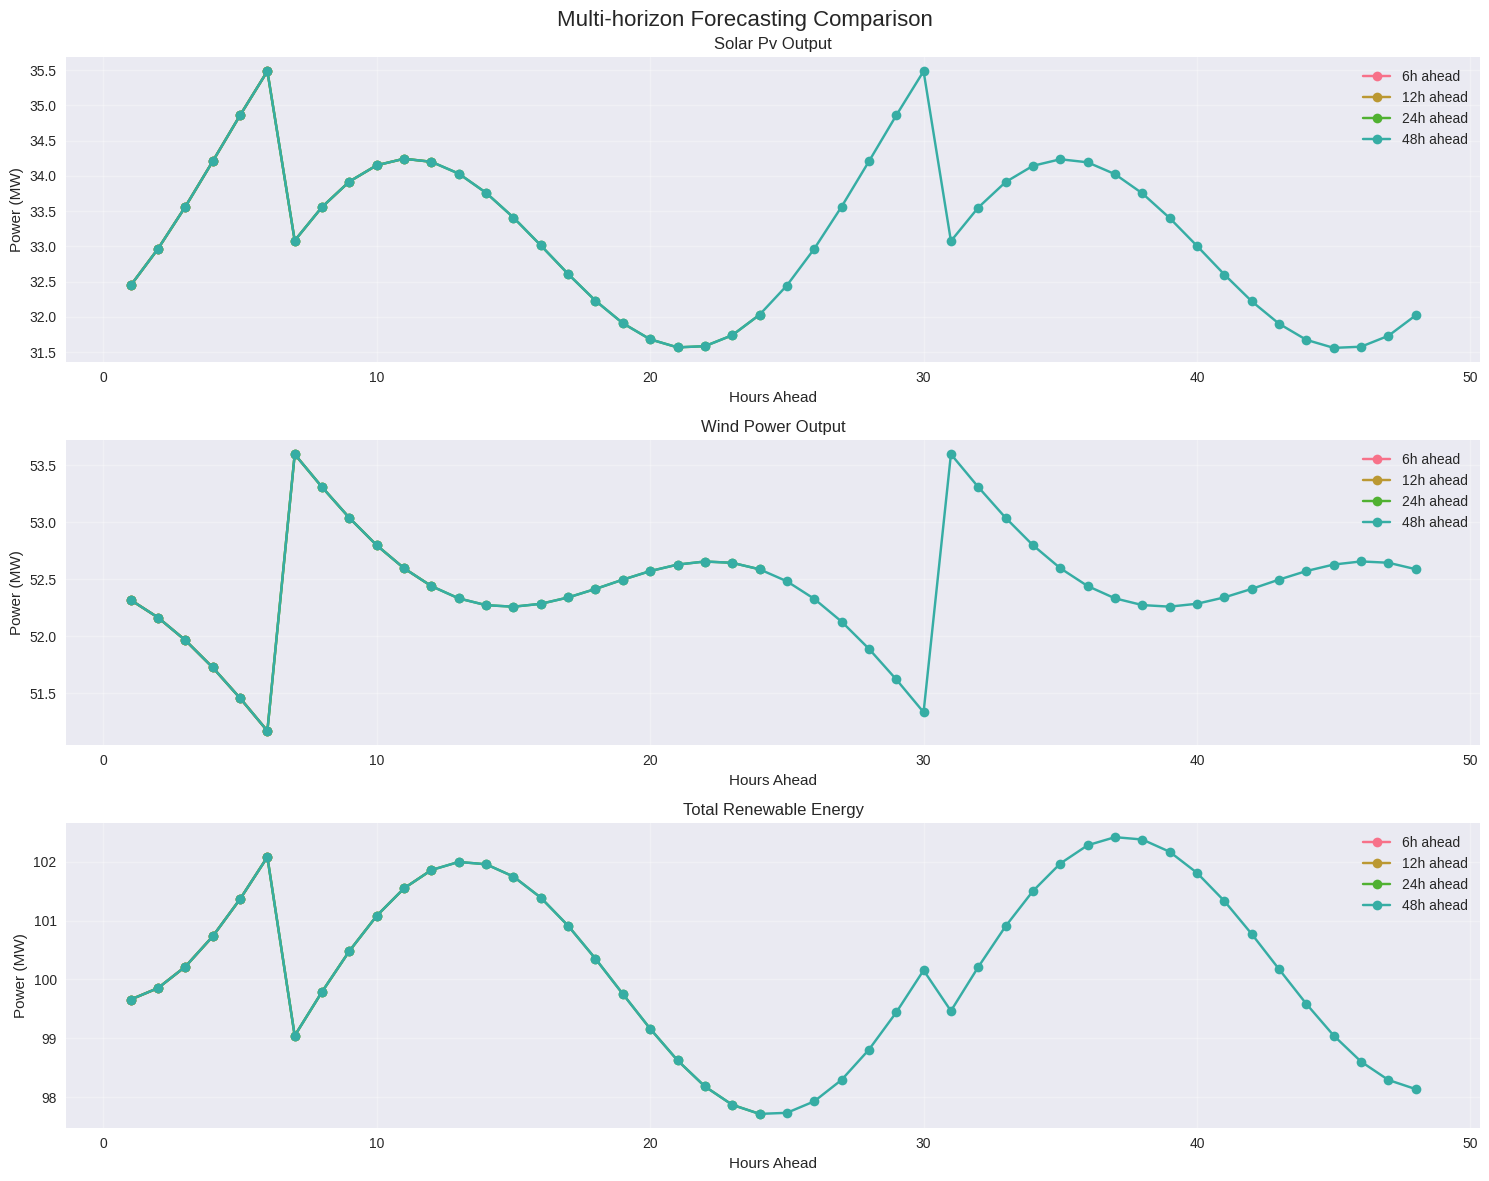

In [ ]:
def create_forecast_comparison():
    """Create a comparison of different forecast horizons"""
    targets = ['solar_pv_output', 'wind_power_output', 'total_renewable_energy']
    horizons = [6, 12, 24, 48]

    fig, axes = plt.subplots(len(targets), 1, figsize=(15, 12))
    fig.suptitle('Multi-horizon Forecasting Comparison', fontsize=16)

    for i, target in enumerate(targets):
        if target in forecaster.models:
            for horizon in horizons:
                forecast = forecaster.predict_next_hours(target, horizon)
                hours = np.arange(1, horizon + 1)
                axes[i].plot(hours, forecast, marker='o', label=f'{horizon}h ahead')

            axes[i].set_title(f'{target.replace("_", " ").title()}')
            axes[i].set_xlabel('Hours Ahead')
            axes[i].set_ylabel('Power (MW)')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

create_forecast_comparison()

🏆 MODEL PERFORMANCE COMPARISON
                           MAE    RMSE  nMAE (%)  nRMSE (%)  Correlation  \
Solar Pv Output         21.929  25.820    21.935     25.827        0.440   
Wind Power Output       22.223  26.426    22.232     26.437        0.412   
Total Renewable Energy  34.285  41.898    17.343     21.194        0.072   

                        Max Error  Mean Absolute % Error  
Solar Pv Output            64.160               2799.622  
Wind Power Output          64.038                500.295  
Total Renewable Energy    102.881                 69.458  


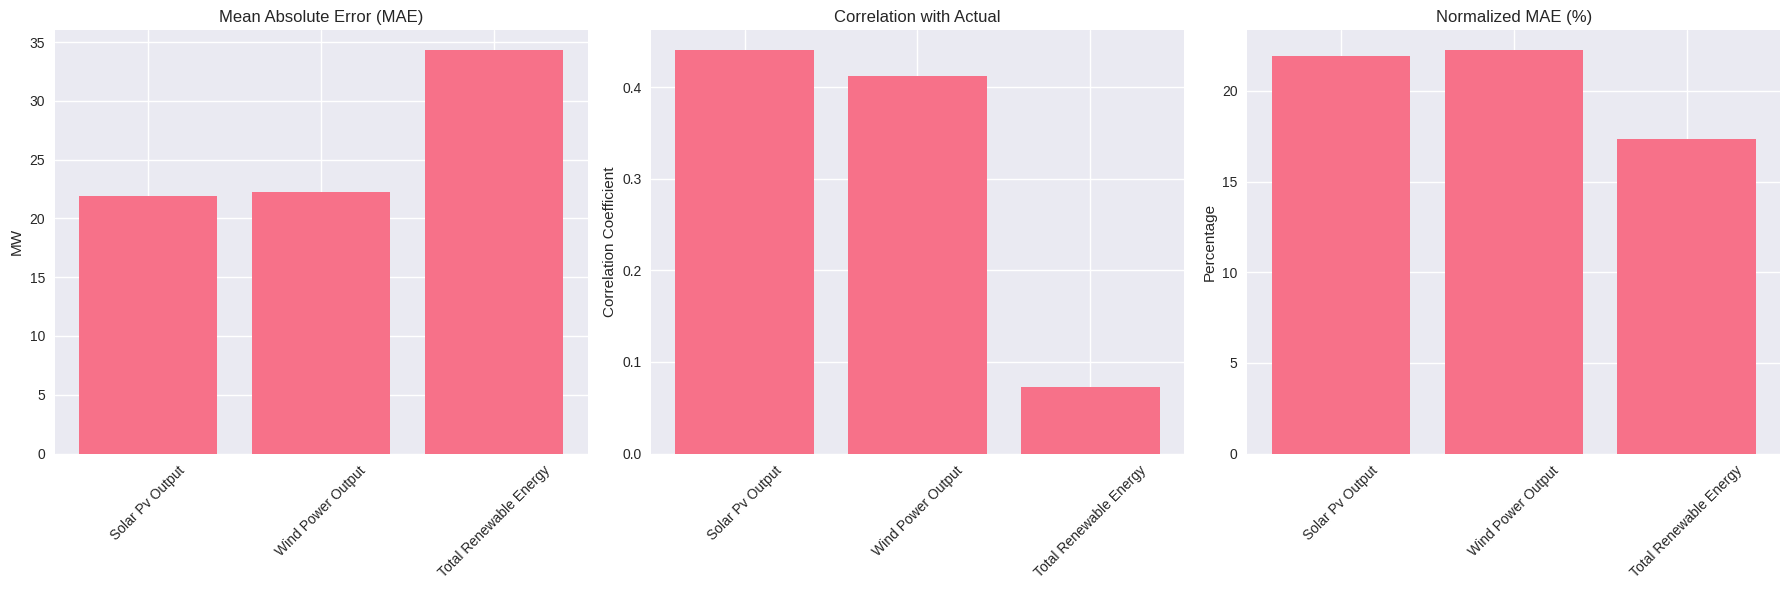

In [ ]:
#Performance Summary Dashboard
def create_performance_dashboard():
    """Create a performance dashboard for all models"""
    targets = ['solar_pv_output', 'wind_power_output', 'total_renewable_energy']

    # Collect metrics
    all_metrics = {}
    for target in targets:
        if target in forecaster.results:
            metrics = forecaster.calculate_simple_metrics(target)
            all_metrics[target] = metrics

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(all_metrics).T
    comparison_df.index = [name.replace('_', ' ').title() for name in comparison_df.index]

    print("🏆 MODEL PERFORMANCE COMPARISON")
    print("="*60)
    print(comparison_df.round(3))

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # MAE Comparison
    axes[0].bar(comparison_df.index, comparison_df['MAE'])
    axes[0].set_title('Mean Absolute Error (MAE)')
    axes[0].set_ylabel('MW')
    axes[0].tick_params(axis='x', rotation=45)

    # Correlation Comparison
    axes[1].bar(comparison_df.index, comparison_df['Correlation'])
    axes[1].set_title('Correlation with Actual')
    axes[1].set_ylabel('Correlation Coefficient')
    axes[1].tick_params(axis='x', rotation=45)

    # nMAE Comparison
    axes[2].bar(comparison_df.index, comparison_df['nMAE (%)'])
    axes[2].set_title('Normalized MAE (%)')
    axes[2].set_ylabel('Percentage')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return comparison_df

performance_summary = create_performance_dashboard()


In [ ]:
#Save Results for Future Use
import pickle
from datetime import datetime

# Save the trained forecaster
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"renewable_forecaster_{timestamp}.pkl"

with open(filename, 'wb') as f:
    pickle.dump(forecaster, f)

print(f"✅ Forecaster saved as: {filename}")
print("📊 You can load it later using:")
print(f"   with open('{filename}', 'rb') as f:")
print("       forecaster = pickle.load(f)")



✅ Forecaster saved as: renewable_forecaster_20250813_161806.pkl
📊 You can load it later using:
   with open('renewable_forecaster_20250813_161806.pkl', 'rb') as f:
       forecaster = pickle.load(f)
